# Searching for a Resonance 

### Omar Moreno (Santa Cruz Institute for Particle Physics, University of California, Santa Cruz)

## Introduction

If a heavy photon does indeed exist and has a mass that is within the acceptance of the Heavy Photon Search detector, it will appear as a resonance above the copious Quantum Electrodynamic trident invariant mass spectrum.  Such a signal would be Gaussian in shape, centered at the $A'$ mass with unknown normalization and a width equal to the mass resolution of HPS at the $A'$ mass. Searching for such a signal can be performed by constructing a window around the $A'$ mass hypothesis and fitting the selected range with a model composed of a polynomial, for the background, and a Gaussian for the signal.  The width and mean of the signal are taken as fixed parameters while the normalization of the Gaussian and coefficients of the polynomial are chosen such that they maximize the Poisson likelihood of the data.  The size of the window is dependent on the mass resolution.

In [2]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import root_numpy as rnp
import ROOT as r
import rootnotes

from rootpy.io import root_open
from scipy import stats

canvas = rootnotes.default_canvas()

# Use the Bayesian Methods for Hackers style
plt.style.use('bmh')
plt.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size' : 20})

## Event Selection

The HPS experiment optimized its trigger to maximize it's acceptance to trident like events.  It is then expected that the final state Trident electron-positron pair will be within the acceptance of both the Ecal and SVT.  This means that both the electron and positron will leave charge depositions in the SVT which can be used to reconstruct the momentum and vertex of the particle, along with energy depositions in the Ecal used for their energy measurement. Because of the good time resolution (~1 ns) of the Ecal, a cluster pair can be easily selected in an event.  The cluster pair can then be matched up to the two electron-positron trident tracks in the event.  

These requirements were applied at the preprocessing level.  Specifically, the two clusters are required to be within a 1.6 ns window relative to each, must be in opposite detector volumes and coplanar. Furthermore, the extrapolated tracks are expected to be within 2 mm of the corresponding clusters.  Events passing these cuts are written out to a flat ROOT tuple for later processing. 

In [3]:
# Path to the ROOT file that will be used to obtain the toy invariant mass distributions used to evaluate the fitter
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass4pt1/mc_1pt05/tridents/trident_analysis.root"
results_rec = rnp.root2array(file_path)

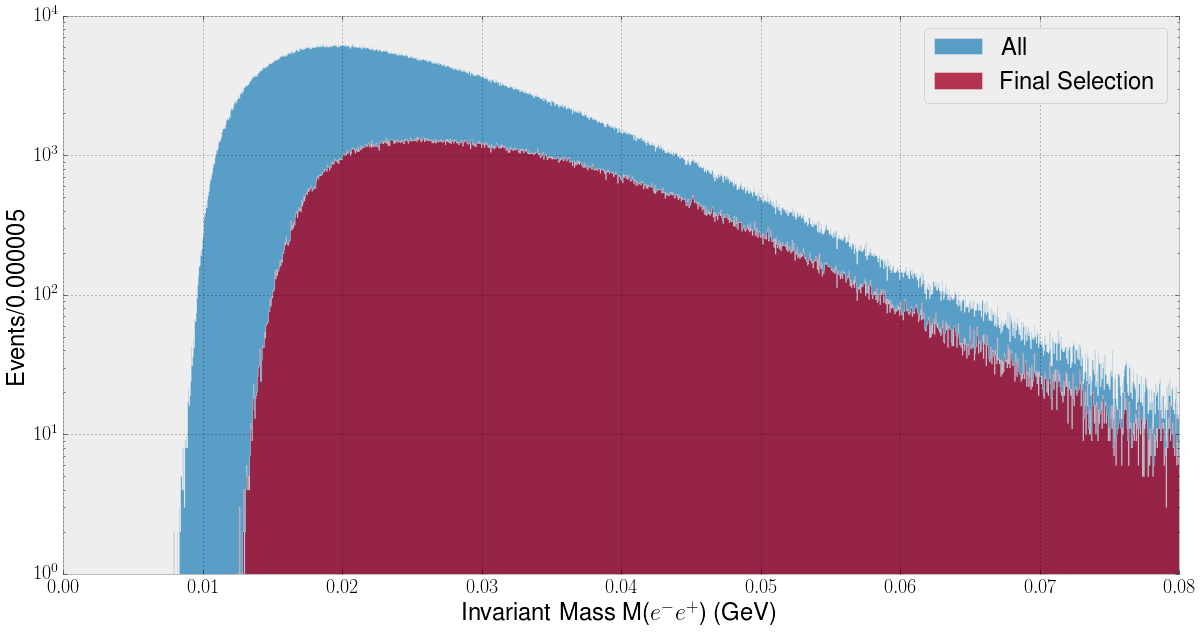

In [4]:
bins = np.linspace(0, 0.1, 2000)

mass_arr = results_rec["invariant_mass"]
electron_chi2_arr = results_rec["electron_chi2"]
positron_chi2_arr = results_rec["positron_chi2"]
e_p_arr = results_rec["electron_p"]
p_p_arr = results_rec["positron_p"]
vx_arr = results_rec["vx"]
vy_arr = results_rec["vy"]
v0_p_arr = results_rec["v0_p"]

mass_arr_cuts = mass_arr[
            (electron_chi2_arr < 15) & (positron_chi2_arr < 15) &
            (e_p_arr < 0.85) & (p_p_arr < 0.85) &
            (((vx_arr*vx_arr/(0.04)) + (vy_arr*vy_arr/(0.0025))) < 1) &
            (v0_p_arr > 0.85)]

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

ax0.hist(mass_arr, bins, alpha=0.8, histtype="stepfilled", label="All")
ax0.hist(mass_arr_cuts, bins, alpha=0.8, histtype="stepfilled", label="Final Selection")
ax0.set_xlabel("Invariant Mass M($e^-e^+$) (GeV)")
ax0.set_ylabel("Events/0.000005")
ax0.set_yscale('log')
ax0.set_xlim(0, 0.08)
ax0.legend(loc=1);


## Mass Resolution

[ -6.16555144e-06   9.06937560e-04  -2.96936354e-03   5.79408513e-01]


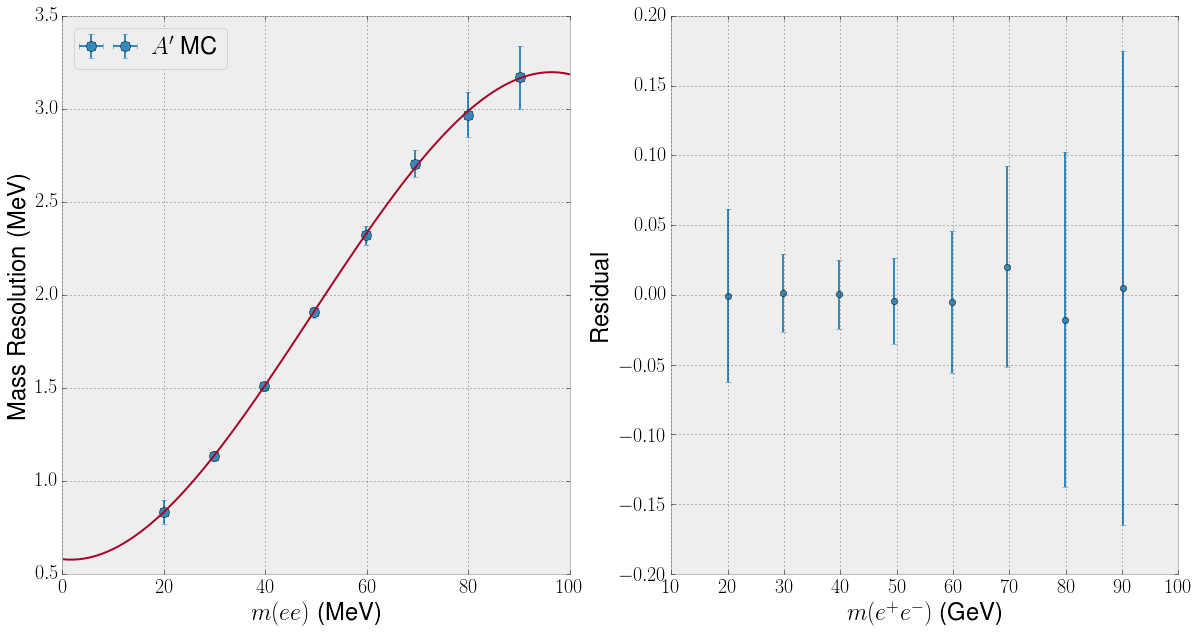

In [5]:
mc_mr = np.genfromtxt("mc_mass_resolution.csv", 
                     dtype=[('mass', 'f8'), 
                            ('mass_error', 'f8'),
                            ('mass_sigma', 'f8'),
                            ('mass_sigma_error', 'f8')],
                     delimiter=","
                    )

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Set the plot labels
ax0.set_xlabel("$m(ee)$ (MeV)")
ax0.set_ylabel("Mass Resolution (MeV)")

# Plot the mass resolutions as a function of mass
ax0.errorbar(mc_mr["mass"]*1000, mc_mr["mass_sigma"]*1000,
             xerr=mc_mr["mass_error"]*1000, yerr=mc_mr["mass_sigma_error"]*1000,
             fmt='o', markersize=10, label="$A'$ MC")
ax0.legend(loc=2)

results = np.polyfit(mc_mr["mass"]*1000,mc_mr["mass_sigma"]*1000, 3)
p = np.poly1d(results)
xp =  np.linspace(0, 100, 100)
ax0.plot(xp, p(xp), '-');
print results

residuals = mc_mr["mass_sigma"]*1000 - p(mc_mr["mass"]*1000)
ax1.errorbar(mc_mr["mass"]*1000, residuals, yerr=mc_mr["mass_sigma_error"]*1000, fmt='o');
ax1.set_xlabel("$m(e^{+}e^{-})$ (GeV)")
ax1.set_ylabel("Residual");

def get_mass_resolution(mass) : 
    return -6.166*math.pow(mass, 3) + 0.9069*math.pow(mass, 2) - 0.00297*mass + 0.000579

## Searching for a Resonance

### Modeling the Distribution of $m_{e^+e^-}$ Events

As discussed in the introduction, if the heavy photon exist, it is expected to appear as a resonance (i.e. an excess) in the measured $e^+e^-$ invariant mass distribution.  The distribution of those events can be described by the probability density function (PDF) <br\>
<center>
$P(m_{e^+e^-}) =  \mu\phi(m_{e^+e^-} | m_{A'}, \sigma) + Bb(m_{e^+e^-}, a_i)$
</center>
Here, $\phi(m_{e^+e^-} | m_{A'}, \sigma)$ is a Gaussian with a mass set to the hypothesized $A'$ mass and width set to the measured experimental mass resolution.  The background within some range, $b(m_{e^+e^-}, a_i)$, is modeled by a 7th order polynomial with the normalization $B$ determined from the data.

In [6]:
# Independent variable
invariant_mass = r.RooRealVar("Invariant Mass", "Invariant Mass (GeV)", 0.0, 0.1)

#
# Signal PDF
#

ap_mass_hypothesis = 0.024525
print "A' mass hypothesis: %f" % (ap_mass_hypothesis)
# The mean of the signal must be set and can't vary
ap_mass_mean = r.RooRealVar("m_{A'}", "m_{A'}", ap_mass_hypothesis)

# The resolution of the signal is set to the value found experimentally
print "A' mass resolution: %f" % (get_mass_resolution(ap_mass_hypothesis))
ap_mass_sigma = r.RooRealVar("m_{\sigma}", "m_{\sigma}", get_mass_resolution(ap_mass_hypothesis))

# Create a gaussian signal pdf with the mean at the mass hypothesis and sigma
# set to the mass resolution
signal = r.RooGaussian("signal", "signal", invariant_mass, ap_mass_mean, ap_mass_sigma)

#
# Background PDF's
#

# Variables used to define polynomials
arg_list = r.RooArgList()
a = []
for order in xrange(1, 8) : 
    name = "t" + str(order)
    a.append(r.RooRealVar(name, name, -2, 2))
    arg_list.add(a[order - 1])
    
bkg = r.RooChebychev("bkg", 
                     "bkg", 
                     invariant_mass, 
                     arg_list)

# Number of events
nsig = r.RooRealVar("signal yield","signal yield", 0., -100000, 100000)
nbkg = r.RooRealVar("bkg yield","bkg yield", 300000., 100., 10000000.) 

#
# Composite model
#

comp_model = r.RooAddPdf("comp model", 
                         "comp model", 
                          r.RooArgList(signal, bkg), 
                          r.RooArgList(nsig, nbkg))

A' mass hypothesis: 0.024525
A' mass resolution: 0.000961


## Maximum Likelihood Fit

In the current analysis, a histogram, $n = (n_1, ..., n_b)$, of the $e^+e^-$ invariant mass serves as the starting point.  For some fixed $A'$ mass and resolution, the expectation value of $n_i$ is <br/>
<center>
$E[n_i] = \mu S_i + B_i$ <br/>
$S_i = \int_bin_i \phi(m_{e^+e^-} | m_{A'}, \sigma) d(m_e^+e^-)$ <br/>
$B_i = \int_bin_i B b(m_{e^+e^-}, a_i) d(m_e^+e^-)$ <br/>
</center>
Estimation of the values of $\mu$ and the nuissance parameters $\theta = (B, a_i)$ of the model above, can be done by maximizing the Poisson likelihood <br/>
<center>
$L(\mu, \theta) = \prod_{j=1}^N \frac{(\mu S_j + B_j)^n_j}{n_j!}e^{-(\mu S_j + B_j)}$
</center>


Fit window size 0.014450
Starting edge of window at 0.017300
Background estimate: 324418.000000


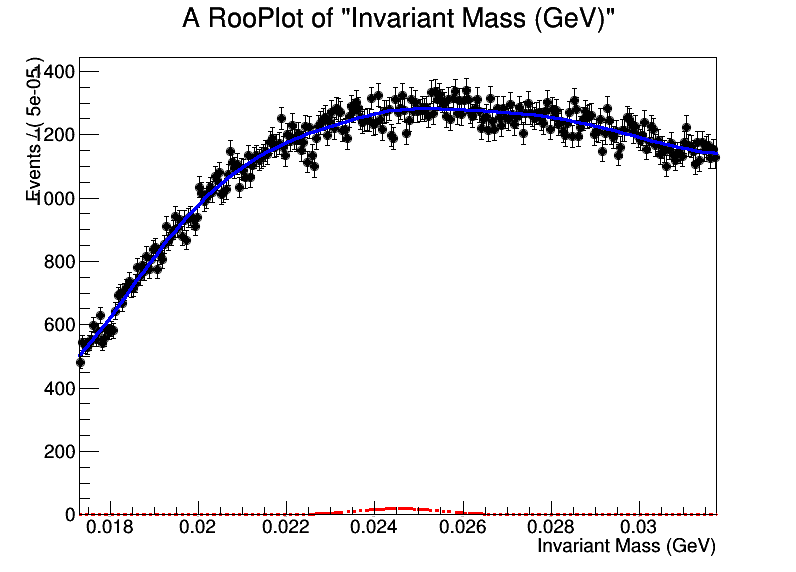

In [7]:
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass4pt1/mc_1pt05/tridents/20160218_invariant_mass_final_mc_b2000.root"
root_file = root_open(file_path)

histos = list(root_file.objects(r.TH1))

# Get the Trident invariant mass histogram from the file
mass_histo = histos[0].Clone()

mass_resolution = get_mass_resolution(ap_mass_hypothesis)

window_size = float('%.4f'%(mass_resolution*15)) + 0.00005
print "Fit window size %f" % (window_size)

window_start = ap_mass_hypothesis - window_size/2
print "Starting edge of window at %f" % (window_start)

invariant_mass.setRange("ap_mass_range", window_start, window_start + window_size)
arg_list = r.RooArgList(invariant_mass)
data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)

integral = data.sumEntries("1", "ap_mass_range")
print "Background estimate: %f" % (integral)
nbkg.setVal(integral)

invariant_mass.setRange(window_start, window_start + window_size)
plot = invariant_mass.frame(r.RooFit.Range("ap_mass_range"))

nll = comp_model.createNLL(data, 
                      r.RooFit.Extended(r.kTRUE), 
                      r.RooFit.Range("ap_mass_range"),
                      r.RooFit.SumCoefRange("ap_mass_range"))

m = r.RooMinuit(nll)
    
m.migrad()

result = m.save()

data.plotOn(plot)
comp_model.plotOn(plot,
                  r.RooFit.Range("ap_mass_range"), 
                  r.RooFit.NormRange("ap_mass_range"))
comp_model.plotOn(plot, 
                 r.RooFit.Range("ap_mass_range"),
                 r.RooFit.NormRange("ap_mass_range"), 
                 r.RooFit.Components("signal"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed),
                 r.RooFit.LineColor(r.RooFit.kRed))

plot.Draw()

# Reset all of the parameters
initial_params = result.floatParsInit()
    
for a_var in a : 
        
    #print "Resetting value of " + str(a_var.GetName())
    #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
    if initial_params.index(a_var.GetName()) == -1 : 
        #print "Variable is not in argument list."
        continue 
    a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
    a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
    #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
    
nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

canvas

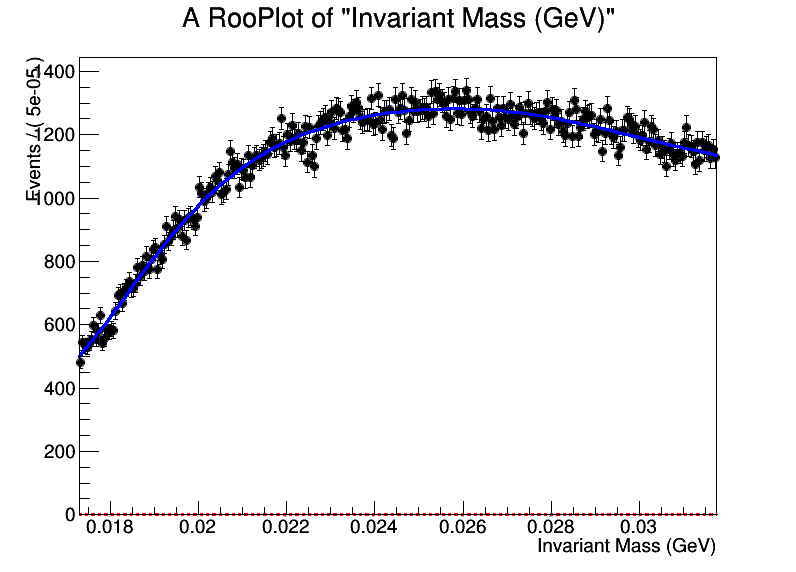

In [8]:
params = comp_model.getVariables()

nsig.setVal(0)

nsig.setConstant(r.kTRUE)

invariant_mass.setRange(window_start, window_start + window_size)
plot = invariant_mass.frame(r.RooFit.Range("ap_mass_range"))

nll = comp_model.createNLL(data, 
                      r.RooFit.Extended(r.kTRUE), 
                      r.RooFit.Range("ap_mass_range"),
                      r.RooFit.SumCoefRange("ap_mass_range"))

m = r.RooMinuit(nll)
    
m.migrad()

bkg_result = m.save()

data.plotOn(plot)
comp_model.plotOn(plot,
                  r.RooFit.Range("ap_mass_range"), 
                  r.RooFit.NormRange("ap_mass_range"))
comp_model.plotOn(plot, 
                 r.RooFit.Range("ap_mass_range"),
                 r.RooFit.NormRange("ap_mass_range"), 
                 r.RooFit.Components("signal"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed),
                 r.RooFit.LineColor(r.RooFit.kRed))

plot.Draw()

canvas




### Discovery

Let $H_0: \mu = 0$ denote the background only hypothesis and $H1: \mu > 0$ be the alternative. 
Establishing whether the signal+background model is significantly different from the background only model is typically done using the profile likelihood ratio and the test statistic $q_0$ <br\>
<center> 
$q_0 = -2 ln \frac{L(0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})} \quad \hat{\mu} > 0$
</center>

According to Wilk's theorem, in the large sample limit the test statistic $q_0$ is asymptotically $\chi^2$ distributed with, in our case, a single degree of freedom.  If the distrution is is given by $f(q_0 | 0)$, a p-value can be calculated as follows
<center>
$p_0 = \int_{q0,obs}^{\infty} f(q_0 | 0) dq_0$
</center>
If the p-value is less than the significance (usually $\alpha = 0.05$ or 95\% confidence), the null hypothesis is rejected in favor of the alternative.  In order words, we found a "bump".

In [9]:
h0_nll = bkg_result.minNll()
h1_nll = result.minNll()

h0_nll *= -1
h1_nll *= -1

diff = h1_nll - h0_nll
q0 = 2*diff

p_value = 1 - stats.chi2.cdf(q0, 1)

print "p-value: %f" % (p_value)


p-value: 0.204685


### Setting a Limit

We can set an upper limit on the coupling strength of the A' as <br\>
<center>$\frac{\alpha}{\alpha}'^{2} = \frac{S_{max}/m_{A'}}{fB/\delta m} \times \frac{2N_{eff}\alpha}{3\pi}$</center>

where $S_{max}$ is the maximum signal, $m_{A'}$ is the mass hypothesis, $f$ is the fraction of radiatives to all tridents, $\alpha$ is the fine structure constant and $B/\delta m$ is the number of background events within a mass window.  It is then crucial to try to maximize the number of radiative events in the final event samples.